In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4.0, 3.0)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["font.size"] = 9
plt.rcParams["legend.frameon"] = False


In [17]:
tables_dir = os.path.join("..", "results", "tables")
exp10_path = os.path.join(tables_dir, "exp10_imagenet_adv_pier.csv")

df = pd.read_csv(exp10_path)
df.head()

,TargetModel,Group,Dose,MeanPIER
0,ResNet18,Standard CNN,0.00,4.552163
1,ResNet18,Standard CNN,0.02,4.476210
2,ResNet18,Standard CNN,0.04,4.404591
3,ResNet18,Standard CNN,0.06,4.349345
4,ResNet18,Standard CNN,0.08,4.295358


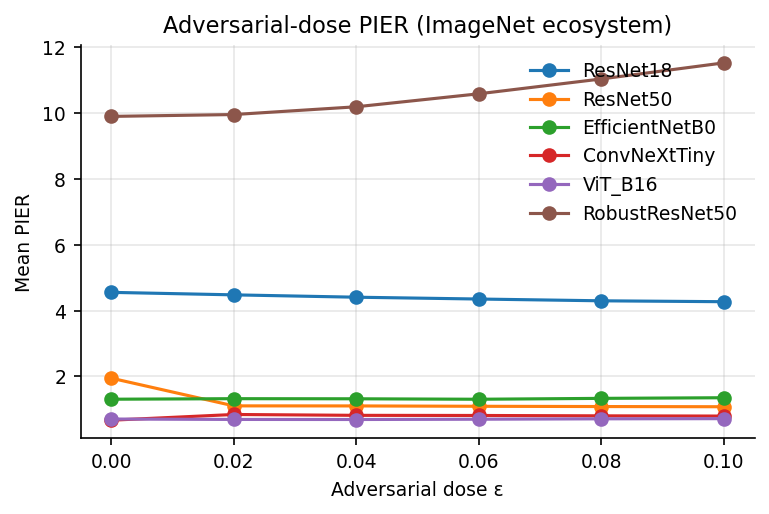

In [13]:
def plot_pier_dose_response(df: pd.DataFrame):
    """
    Plot PIER dose-response curves for all target models.
    """
    models = df["TargetModel"].unique().tolist()
    doses = sorted(df["Dose"].unique())

    plt.figure(figsize=(5.2, 3.5))

    for name in models:
        sub = df[df["TargetModel"] == name].sort_values("Dose")
        plt.plot(
            sub["Dose"].values,
            sub["MeanPIER"].values,
            marker="o",
            label=name,
        )

    plt.xlabel("Adversarial dose ε")
    plt.ylabel("Mean PIER")
    plt.title("Adversarial-dose PIER (ImageNet ecosystem)")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_pier_dose_response(df)


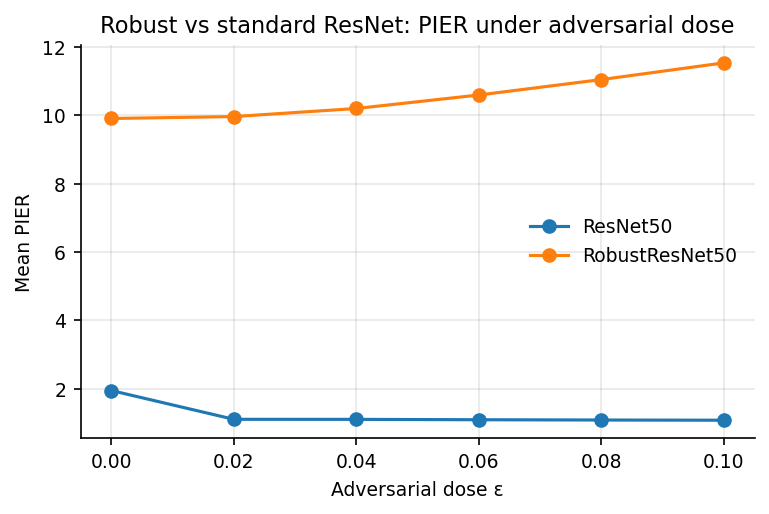

In [14]:
def plot_pier_robust_vs_standard(df: pd.DataFrame):
    """
    Plot PIER dose-response highlighting RobustResNet50 vs standard ResNet50.
    If RobustResNet50 is not present, this falls back to plotting all models.
    """
    models = df["TargetModel"].unique().tolist()

    if "RobustResNet50" in models and "ResNet50" in models:
        selected = ["ResNet50", "RobustResNet50"]
    else:
        selected = models

    plt.figure(figsize=(5.2, 3.5))
    for name in selected:
        sub = df[df["TargetModel"] == name].sort_values("Dose")
        plt.plot(
            sub["Dose"].values,
            sub["MeanPIER"].values,
            marker="o",
            label=name,
        )

    plt.xlabel("Adversarial dose ε")
    plt.ylabel("Mean PIER")
    plt.title("Robust vs standard ResNet: PIER under adversarial dose")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_pier_robust_vs_standard(df)


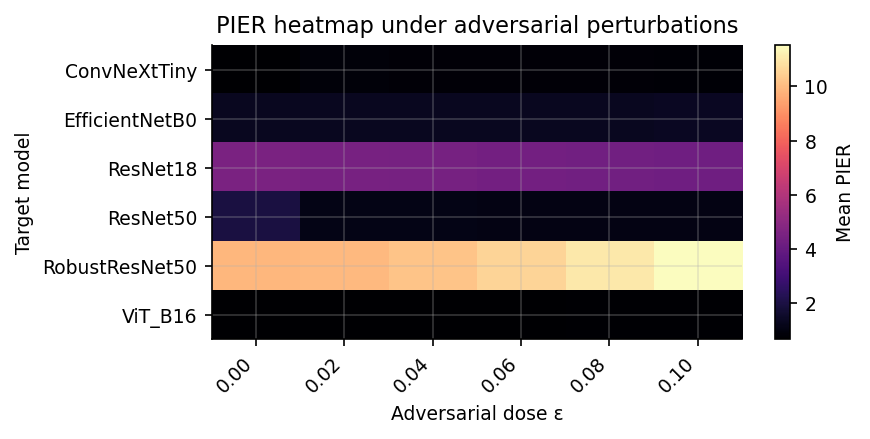

In [15]:
def plot_pier_heatmap(df: pd.DataFrame):
    """
    Plot a heatmap of MeanPIER (rows = models, columns = doses).
    """
    pivot = df.pivot_table(
        index="TargetModel",
        columns="Dose",
        values="MeanPIER",
        aggfunc="mean",
    )

    plt.figure(figsize=(6.0, 3.0))
    im = plt.imshow(pivot.values, aspect="auto", cmap="magma")

    plt.yticks(
        np.arange(len(pivot.index)),
        pivot.index,
    )
    plt.xticks(
        np.arange(len(pivot.columns)),
        [f"{d:.2f}" for d in pivot.columns],
        rotation=45,
        ha="right",
    )

    plt.xlabel("Adversarial dose ε")
    plt.ylabel("Target model")
    plt.title("PIER heatmap under adversarial perturbations")
    plt.colorbar(im, label="Mean PIER")
    plt.tight_layout()
    plt.show()


plot_pier_heatmap(df)
